In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [4]:
df.shape

(4857377, 8)

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Timestamp'] = pd.to_datetime(df['Timestamp']).dt.to_period('m')
df.set_index(df['Timestamp'], inplace=True)
df.drop(['Timestamp'],axis=1,inplace=True)
df=df.to_timestamp()

In [6]:
(df.isnull().sum()/df.shape[0])*100

Open                 25.60246
High                 25.60246
Low                  25.60246
Close                25.60246
Volume_(BTC)         25.60246
Volume_(Currency)    25.60246
Weighted_Price       25.60246
dtype: float64

In [7]:
df.fillna(method='ffill', inplace=True)
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-01,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-01,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-01,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-01,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-01,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


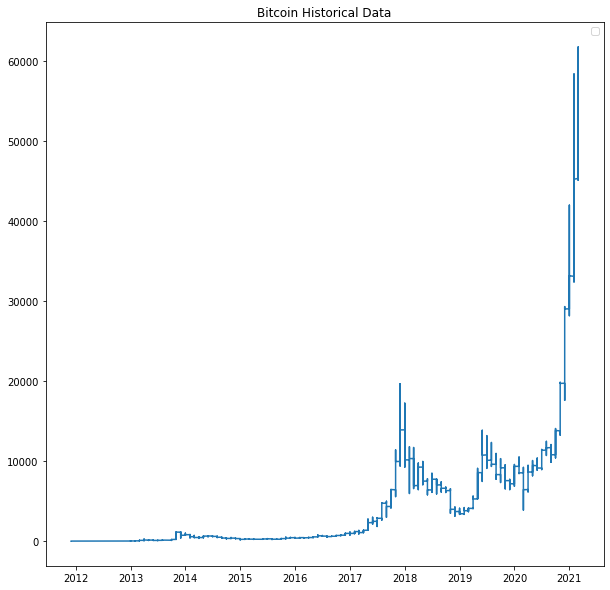

In [8]:
plt.figure(figsize=[10,10])
plt.legend(loc='best')
plt.title('Bitcoin Historical Data')
plt.plot(df['Weighted_Price'])
plt.show()

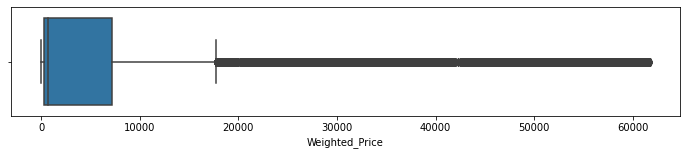

In [9]:
import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=df['Weighted_Price'],whis=1.5)

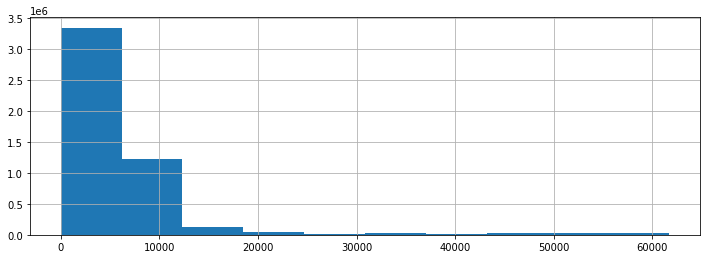

In [10]:
fig = df.Weighted_Price.hist(figsize = (12,4))

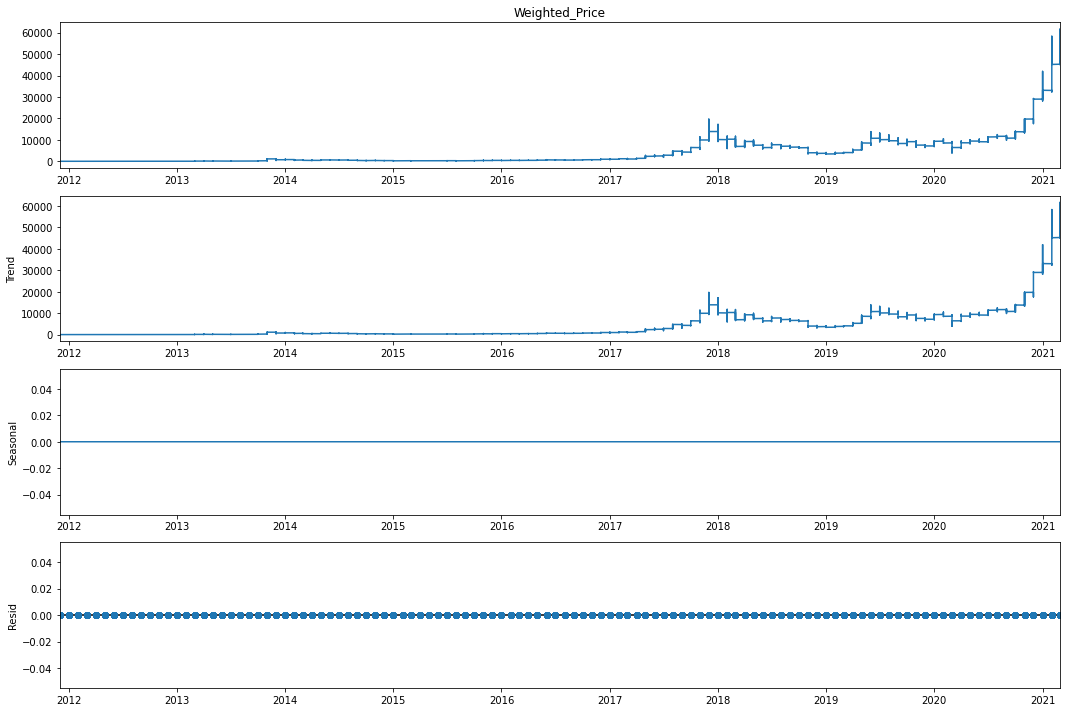

In [11]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(df.Weighted_Price, model='additive',period=1) 
fig = decomposition.plot()
plt.show()

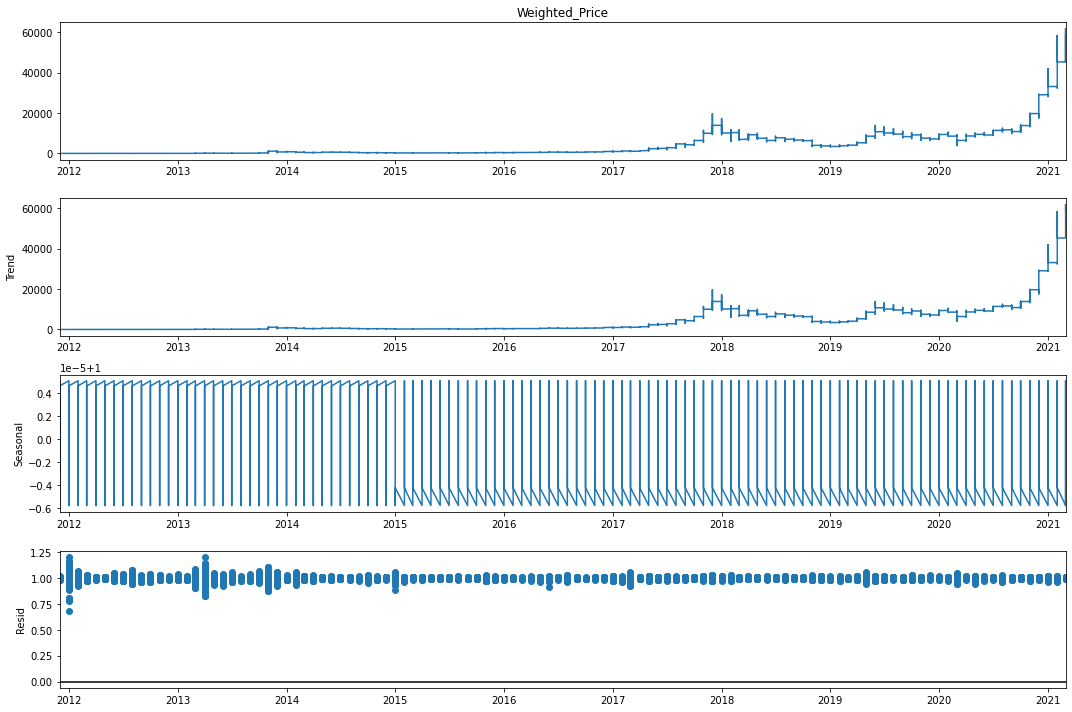

In [12]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 15, 10
decomposition = sm.tsa.seasonal_decompose(df.Weighted_Price, model='multiplicative',period=12) 
fig = decomposition.plot()
plt.show()

In [13]:
data = df[['Close']]
train_len = int(0.7 * len(df.Close))
test_len = len(df.Close) - train_len
train = data[0:train_len] # first 70% as training set
test = data[train_len:] 

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Close'])
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(len(test))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


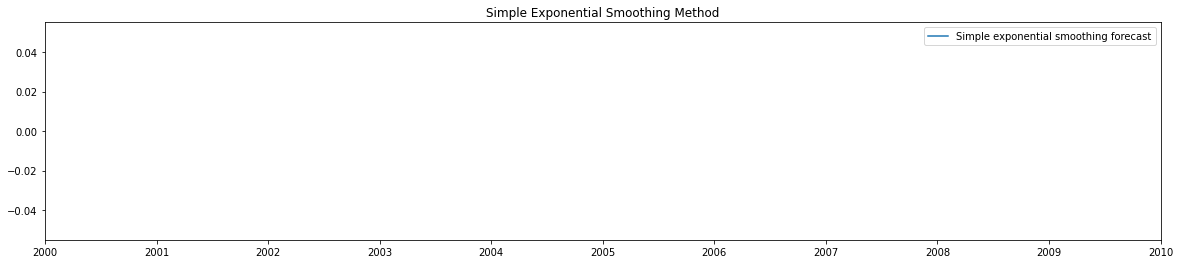

In [15]:
plt.figure(figsize=(20,4))
plt.plot(y_hat_ses['ses_forecast'], label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  This is separate from the ipykernel package so we can avoid doing imports until


{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 4.389999999999998, 'initial_trend': 1.6653345369377348e-16, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


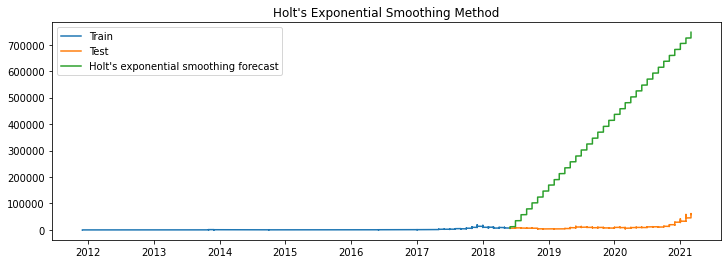

In [17]:
plt.figure(figsize=(12,4))
plt.plot( train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Method')
plt.show()